<br>
<center> <h2>Maestría en Inteligencia Analítica para la Toma de Decisiones</h2> </center>
<center> <h3>Modelos avanzados para análisis de datos 1</h3> </center>
<br>
<h3>P2 - Used Vehicle Price Prediction</h3>

 

##### Presentado por:
    Camilo Andres Suarez Trillos      (200321493)
    Daniel Augusto Leon Moreno        (201920439)
    Hector Fabian Rodriguez Mayorga   (201921382)
    Carlos Andres Paez Rojas          (201924257)

 

<h4> Junio 2020</h4>
<br>

# Exercise 8

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
# Ejecucion de librerias

%matplotlib inline
import pandas as pd
import numpy as np

import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [3]:
data.shape

(13150, 10)

In [4]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
reg = LinearRegression().fit(X_train, y_train)

valores = (reg.predict(X_test)>0.5).astype(int)
valores

array([0, 1, 1, ..., 1, 1, 0])

In [7]:
print(confusion_matrix(y_test, valores))
print()
print(accuracy_score(y_test, valores))

[[1232  580]
 [  52 2476]]

0.8543778801843318


Como se observa con la métrica de desempeño, tenemos un accuracy de **85.43%** para la regresión lineal, al predecir el precio de un carro en alto y bajo, con un threshold de 0.5

# Exercise 8.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [8]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [9]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [10]:
def best_split(X, y, num_pct):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [11]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [12]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5606,
  'gain': 0.03317687167496233,
  'sl': {'y_pred': 0,
   'y_prob': 0.36828644501278773,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 389,
   'gain': 0.05908490521197157,
   'sl': {'y_pred': 0,
    'y_prob': 0.08,
    'level': 3,
    'split': -1,
    'n_samples': 98,
    'gain': 0.01707452211653898},
   'sr': {'y_pred': 0,
    'y_prob': 0.46757679180887374,
    'level': 3,
    'split': -1,
    'n_samples': 291,
    'gain': 0.036947257392555666}},
  'sr': {'y_pred': 1,
   'y_prob': 0.8743054224947308,
   'level': 2,
   'split': [0, 2015.0],
   'n_samples': 5217,
   'gain': 0.014933378976312917,
   'sl': {'y_pred': 1,
    'y_prob': 0.7348484848484849,
    'level': 3,
    'split': -1,
    'n_samples': 1450,
    'gain': 0.024495220

In [13]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [14]:
valores2 = tree_predict(X_test, tree)

print(confusion_matrix(y_test, valores2))
print()
print(accuracy_score(y_test, valores2))

[[1466  346]
 [ 257 2271]]

0.8610599078341014


Con el árbol de decisión, tenemos una mejora en la métrica del accuracy con respecto a lo identificado en la regresión lineal, llegando a un accuracy del **86.10%** para predecir el precio de un carro.

# Exercise 8.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #7

Evaluate the accuracy on the testing set

In [15]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = X.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([ 3582, 11646,  1346, ...,  7609,   826, 12472]),
 array([10086, 12583,  8676, ...,  6654, 12680,  6930]),
 array([ 3187,  9506, 13104, ...,   514, 11198, 12789]),
 array([ 7975,  7978, 10938, ...,  9423,  6330,   143]),
 array([10073, 10404,  3054, ...,  8839,  2273, 11157]),
 array([ 5772,  6551,  9436, ..., 11150, 11918,  6274]),
 array([1233, 2545, 3665, ..., 1811, 7815, 6039]),
 array([10496,  4279,  5665, ...,  2733,  1011,   606]),
 array([ 2134,  6321,  9507, ...,  6330, 12601,  5561]),
 array([12956,  4255,  7224, ...,  9162,  3592, 10236])]

In [16]:
# show the rows for the first decision tree
X.iloc[samples[0], :]

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
134710,2014,25215,0,0,0,0,1,0,0
442096,2016,23390,0,0,0,0,1,0,0
51508,2016,40696,0,0,0,0,0,0,1
467468,2014,90824,0,0,0,0,0,1,0
194791,2015,39696,0,0,0,0,1,0,0
293571,2010,94739,0,0,0,0,1,0,0
370538,2014,44678,0,0,0,0,0,1,0
278784,2010,163105,0,1,0,0,0,0,0
219428,2017,15338,0,0,0,0,0,1,0
3809,2014,84650,1,0,0,0,0,0,0


In [17]:
X_test

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
332784,2012,37294,0,1,0,0,0,0,0
146436,2015,45405,0,0,0,0,0,1,0
130476,2016,30648,0,0,0,0,0,1,0
85618,2015,27313,0,0,0,0,0,1,0
75474,2009,123815,0,1,0,0,0,0,0
330419,2012,83180,0,1,0,0,0,0,0
205915,2016,45839,0,0,0,0,0,1,0
2836,2015,54139,0,0,0,0,0,1,0
250833,2015,39691,0,0,0,0,0,1,0
126784,2009,143903,0,1,0,0,0,0,0


In [20]:
X.iloc[sample, 0:]

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
492804,2015,16566,0,0,0,0,0,0,1
158640,2014,17199,0,0,0,0,1,0,0
272300,2005,145490,0,1,0,0,0,0,0
306238,2014,52162,0,0,0,0,0,1,0
341316,2017,35351,0,0,0,0,1,0,0
489065,2016,14748,0,0,0,0,0,1,0
190058,2012,78937,0,0,0,0,1,0,0
370557,2015,47264,0,0,0,0,1,0,0
339300,2012,50732,0,1,0,0,0,0,0
8799,2012,47435,0,1,0,0,0,0,0


In [18]:
# grow each tree deep
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame for storing predicted price from each tree
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# grow one tree for each bootstrap sample and make predictions on testing data
for i, sample in enumerate(samples):
    X_train_r = X.iloc[sample, 0:]
    y_train_r = y.iloc[sample]
    treereg.fit(X_train_r, y_train_r)
    y_pred[[i]] = treereg.predict(X_test)

En el siguiente Dataframe representamos la predicción de la muestra de test para los 10 eventos aleatorios definidos inicialmente.

In [19]:
y_pred

,0,1,2,3,4,5,6,7,8,9
332784,1.0,1.00,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
146436,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
130476,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
85618,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75474,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
330419,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205915,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2836,1.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
250833,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
126784,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


En resumen, el error cuadrático medio para cada uno de los eventos.

In [20]:
for i in range(n_B):
    print(i, np.sqrt(mean_squared_error(y_pred[[i]], y_test)))

0 0.26107386351755235
1 0.2543968198218757
2 0.2515181757430955
3 0.2461720504919687
4 0.24745569097601244
5 0.24975666601134372
6 0.2590526875577159
7 0.25479327081988395
8 0.24478511644206183
9 0.2524331163667067


Como siguiente medida, obtenemos el promedio lineal de las predicciones de los 10 eventos generados.

In [21]:
y_pred_mean = y_pred.mean(axis=1)
y_pred_mean = ((y_pred_mean)>0.5).astype(int)
y_pred_mean

332784    1
146436    1
130476    1
85618     1
75474     0
330419    0
205915    1
2836      0
250833    1
126784    0
70347     1
63289     1
112205    1
110630    1
458256    1
371230    0
130467    0
457797    1
367064    0
131705    1
484284    0
482990    0
294535    0
365460    0
64466     1
356183    0
332219    0
480099    1
250250    1
116789    0
         ..
320236    1
105104    1
214655    0
266700    0
115954    0
273953    1
334056    1
417586    0
74732     1
118259    0
431992    0
475814    0
43386     0
452397    1
392445    1
246910    0
323580    1
192225    1
252987    1
178362    1
58768     1
123468    0
272289    1
325203    1
86246     1
244795    1
366403    0
269482    1
5010      1
310628    0
Length: 4340, dtype: int32

In [22]:
np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))

0.1455489165371351

En promedio tenemos un **MSE** de **0.1455**

In [23]:
print(accuracy_score(y_test, y_pred_mean))

0.9824884792626728


Con un modelo Bagging se identifica un mayor desempeño para predecir el precio de un carro, logrando un accuracy de **98.24%**.

# Exercise 8.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [24]:
def best_split(X, y, num_pct, max_features):
    
    np.random.seed(123)
    nums = range(X.shape[1])
    features = np.random.choice(a=nums, size=max_features, replace=False)
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [25]:
def tree_grow_1(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=1):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct, max_features)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Check stooping max_features
    if j >= max_features:
        return tree
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow_1(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, max_features=max_features)
    tree['sr'] = tree_grow_1(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, max_features=max_features)
    
    return tree

In [26]:
accuracy_scr = pd.Series(np.random.rand(len(X.columns)))  
eje_y = pd.Series(np.random.rand(len(X.columns)))  
for i in range(1, len(X.columns)+1): 
    tree = tree_grow_1(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10, max_features=i)
    valores2 = tree_predict(X_test, tree)
    accuracy_scr[i] =accuracy_score(y_test, valores2) 
    eje_y[i] = i

In [58]:
accuracy_scr

0    0.591541
1    0.582488
2    0.849539
3    0.849539
4    0.849539
5    0.849539
6    0.861060
7    0.861060
8    0.861060
9    0.861060
dtype: float64

Text(0, 0.5, 'Accuracy')

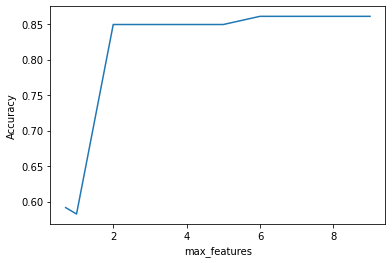

In [27]:
plt.plot(eje_y, accuracy_scr)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

Evaluando el parámetro de max_features en el modelo definido, observamos un accuracy máximo de **86.10%** a partir de 6 variables.

# Exercise 8.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [28]:
n_estimators = 10
n_features = 6

In [29]:
n_samples = X_train.shape[0]

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [30]:
np.random.seed(123) 

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features=int(math.log(n_features)), max_depth=None, random_state=0)
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [31]:
# Predict 
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9
332784,0,0,0,0,1,1,0,1,1,1
146436,1,1,1,1,1,1,1,1,1,1
130476,1,1,1,1,1,1,1,1,1,1
85618,1,1,1,1,1,1,1,1,1,1
75474,0,0,0,0,0,0,0,0,0,0


In [32]:
y_pred_df.sum(axis=1)[:10]

332784     5
146436    10
130476    10
85618     10
75474      0
330419     0
205915    10
2836       8
250833    10
126784     0
dtype: int64

In [33]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

metrics.f1_score(y_pred, y_test)

0.8676441837732161

In [34]:
metrics.accuracy_score(y_pred, y_test)

0.8440092165898617

Aplicando el Log al parámetro n_features en un modelo Bagging, observamos una pequeña desmejora en el accuracy de 0.017bp con respecto a lo obtenido en el proceso anterior.

# Exercise 8.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [35]:
rfc = RandomForestClassifier(n_estimators=n_estimators, max_features=9, random_state=1, n_jobs=-1)
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [39]:
feature_cols = X.columns
pd.DataFrame({'feature':feature_cols, 'importance':rfc.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000005
3,M_Camry4dr,0.001761
5,M_CamryL,0.004887
7,M_CamrySE,0.006293
2,M_Camry,0.007455
8,M_CamryXLE,0.008267
6,M_CamryLE,0.014692
0,Year,0.200845
1,Mileage,0.755795


In [40]:
y_pred = rfc.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 0])

In [41]:
metrics.accuracy_score(y_pred, y_test)

0.9836405529953917

Con un modelo Random Forest se identifica el mejor desempeño para predecir el precio de un carro, logrando un accuracy de **98.36%** (algo similar a los 10 eventos aleatorios generados con el modelo Bagging en el numeral 8.2)

# Exercise 8.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [42]:
# list of values to try for n_estimators
estimator_range = range(1, 30, 2)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

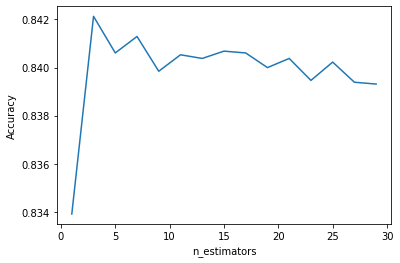

In [43]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

Como se observa en la gráfica anterior, identificamos el mejor desempeño en predecir el precio de un carro con 3 estimadores.

In [44]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=3, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

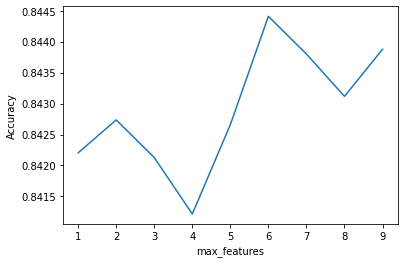

In [45]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

Por consiguiente, con 3 estimadores, en la gráfica anterior observamos el mejor desempeño usando 6 variables para el parámetro max_features.

In [64]:
# list of values to try for n_estimators
estimator_range = range(1, 10, 1)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=3, max_features=6, max_depth=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

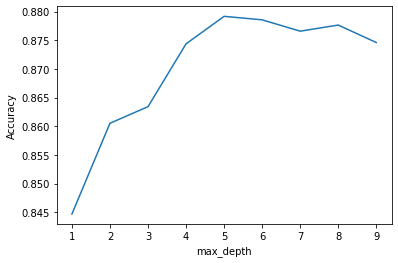

In [66]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

Finalmente, con 3 estimadores y max_features = 6, en la gráfica anterior observamos el mejor desempeño usando max_depth = 5.

In [67]:
# max_features=6 is best and n_estimators=3 is sufficiently large
clf = RandomForestClassifier(n_estimators=3, max_features=6, max_depth=5, random_state=1, n_jobs=-1)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=-1,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [68]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
5,M_CamryL,0.000000
4,M_CamryBase,0.000004
7,M_CamrySE,0.000827
2,M_Camry,0.003485
8,M_CamryXLE,0.004435
6,M_CamryLE,0.010954
0,Year,0.124124
3,M_Camry4dr,0.132481
1,Mileage,0.723690


In [69]:
y_pred = rfc.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 0])

In [70]:
metrics.accuracy_score(y_pred, y_test)

0.9836405529953917

Estimando los parámetros en estimadores = 3, max_features = 6 y max_depth = 5, observamos finalmente en la gráfica anterior el mejor desempeño obtenido, con un accuracy de 98.36%

# Exercise 8.7 

Using xgboost train a XGBClassifier 

Evaluate the accuracy on the testing set

In [50]:
clf = XGBClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

(0.8989412897016361, 0.8790322580645161)

Calibrando el modelo para predecir el precio de un carro con XGBClassifier obtenemos como métricas de desempeño F1_score = **89.89%** y accuracy de **87.90%**, una considerable desmejora con respecto a los modelos definidos anteriormente.

# Exercise 8.8

Using xgboost train a XGBClassifier 

Modify the parameters learning rate, gamma, colsample_bytree. Explain what each parameter means.

Evaluate the accuracy on the testing set

In [51]:
eta_ini = 0.01
eta_fin = 0.3

# list to store the average Accuracy for each value of max_features
accuracy_scores = []
feature_range = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
while eta_ini <= eta_fin:
    clf = XGBClassifier(eta=eta_ini, gamma=0, colsample_bylevel=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(metrics.accuracy_score(y_pred, y_test.values))
    feature_range.append(eta_ini)
    eta_ini = eta_ini + 0.01

La grafica siguiente corresponde a la evolución del accuracy modificando el parámetro **learning rate** entre 0.01 y 3.

Text(0, 0.5, 'Accuracy')

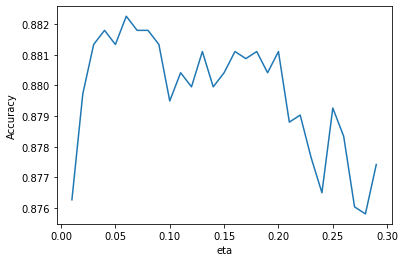

In [52]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('eta')
plt.ylabel('Accuracy')

In [53]:
gamma_ini = 0.5
gamma_fin = 0.7

# list to store the average Accuracy for each value of max_features
accuracy_scores = []
feature_range = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
while gamma_ini <= gamma_fin:
    clf = XGBClassifier(eta=0.06, gamma=gamma_ini, colsample_bylevel=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(metrics.accuracy_score(y_pred, y_test.values))
    feature_range.append(gamma_ini)
    gamma_ini = gamma_ini + 0.01

Definiendo el parámetro **eta** en **0,06**, la siguiente gráfica corresponde a la evolución del accuracy modificando el parámetro **gamma** entre 0.5 y 0.7.

Text(0, 0.5, 'Accuracy')

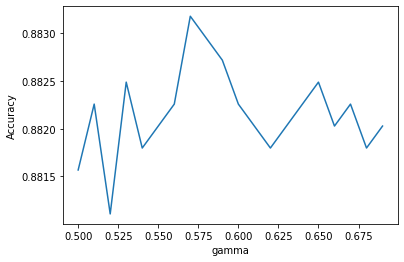

In [54]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('gamma')
plt.ylabel('Accuracy')

In [55]:
colsample_ini = 0.60
colsample_fin = 0.80

# list to store the average Accuracy for each value of max_features
accuracy_scores = []
feature_range = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
while colsample_ini <= colsample_fin:
    clf = XGBClassifier(eta=0.06, gamma=0.57, colsample_bylevel=colsample_ini)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(metrics.accuracy_score(y_pred, y_test.values))
    feature_range.append(gamma_ini)
    colsample_ini = colsample_ini + 0.01

Definiendo el parámetro **eta** en **0,06**, **gamma** en **0.57**, la siguiente gráfica corresponde a la evolución del accuracy modificando el parámetro **colsample_bylevel** de 0.6 a 0.8.

Text(0, 0.5, 'Accuracy')

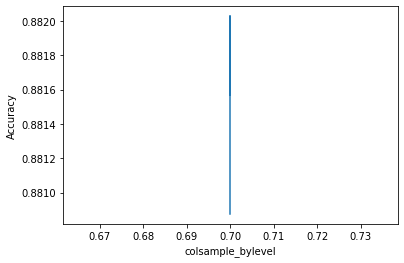

In [56]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('colsample_bylevel')
plt.ylabel('Accuracy')

In [57]:
clf = XGBClassifier(eta=0.06, gamma=0.57, colsample_bylevel=0.7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

(0.9016141429669485, 0.8820276497695853)

Así finalmente, definiendo los parámetros **eta** en **0,06**, **gamma** en **0.57** y **colsample_bylevel** en **0.7**, se logra el mayor desempeño para el modelo XGBClassifier con un accuracy del **88.20%**, aunque es considerablemente más bajo que el desempeño del RandomForestClassifier definido anteriormente.

Finalmente concluimos que el mejor modelo para predecir el precio de un carro en alto y bajo es Random Forest, con mayor accuracy obtenido de **98.36%**

## Definición de parámetros

#### Learning rate: (o ETA) 

Hace que el modelo sea más robusto al reducir los pesos en cada paso. Valores finales típicos a utilizar estan entre 0.01-0.2 Grading Boosting implica crear y agregar árboles al modelo secuencialmente. Se crean nuevos árboles para corregir los errores residuales en las predicciones de la secuencia existente de árboles. El efecto es que el modelo puede adaptarse rápidamente y luego sobreajustar el conjunto de datos de entrenamiento.

Una técnica para ralentizar el aprendizaje en el modelo XGBoost es aplicar un factor de ponderación para las correcciones de los nuevos árboles cuando se agregan al modelo. Esta ponderación se denomina factor de contracción o tasa de aprendizaje, según la literatura o la herramienta.

Establecer valores inferiores a 1.0 tiene el efecto de hacer menos correcciones para cada árbol agregado al modelo. Esto a su vez da como resultado más árboles que deben agregarse al modelo. Es común tener valores pequeños en el rango de 0.1 a 0.3, así como valores menores a 0.1.

#### Gamma: 

Reducción de pérdida mínima requerida para realizar una partición adicional en un nodo hoja del árbol. Cuanto mayor sea la gamma, más conservador será el algoritmo.

El rango de ese parámetro es [0, Infinito [. Encontrar una gamma "buena" depende mucho del conjunto de datos y de los otros parámetros que se estén utilizando. No hay una gamma óptima para un conjunto de datos, solo hay una gamma óptima (valor real) dependiendo del conjunto de entrenamiento + los otros parámetros que esté utilizando.



#### Colsample_bytree: 

Similar a max_features en GBM. Denota la fracción de columnas para ser muestras aleatorias para cada árbol, Valores típicos: 0.5-1